In [218]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
from urllib.parse import urlparse, urljoin
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
import numpy as np
from matplotlib.ticker import FuncFormatter
import requests
import scipy.stats as sps
from urllib.parse import quote


# enable horizontal scroll of data frame in Jupyter lab
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

pd.options.display.html.use_mathjax = False
pd.options.display.min_rows = 100
pd.options.display.max_rows = 100


# Part A: Download all of electionline weekly

In [220]:
YEARS = reversed(range(2011, 2024))

# Define user-agent to simulate a web browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

base_url = 'https://electionline.org'

for year in YEARS:
    dir_path = f"electionline-weekly/{year}"
    os.makedirs(dir_path, exist_ok=True)
    
    url = f"{base_url}/electionline-weekly/{year}"
    
    # Send an HTTP GET request with headers
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser')
    
    weeks = soup.find('ul', class_='weeks').find_all('li')
    weeks = [f"{base_url}{week.find('a')['href']}" for week in weeks]

    for week in weeks:
        response = requests.get(week, headers=headers)
        with open(f"{week.split('electionline.org/')[-1]}.html", 'w') as f:
            f.write(response.text)


# Part B: Manual scraping with regex

Go through all the saved HTML, and make each paragraph a row in a pandas data frame. Use regex to pull out key details.

In [114]:
YEARS = reversed(range(2011, 2024))

job_df = pd.DataFrame()

for year in YEARS:
    dir = f"electionline-weekly/{year}"
    weeks = os.listdir(dir)

    for week in weeks:
        date = week[:5]
        
        with open(os.path.join(dir, week)) as f:
            text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
    
        # Find all divs with the class 'article-wrapper'
        divs_with_class = soup.find_all('div', class_='article-wrapper')
    
    
        for div in divs_with_class:
            h2_tags = div.find_all('h2', string=re.compile(r'^job', re.I))
            
            if h2_tags:
                for h2_tag in h2_tags:
                    # Find all p elements within the div containing the matched h2 tag
                    # Skip the first paragraph
                    job_paragraphs = div.find_all('p')[1:]  

                    # Skip intro and empty paragraphs
                    job_paragraphs = [para for para in job_paragraphs if (not para.text.startswith('electionlineWeekly')) and (len(para.text)>10)]    
                    
                    for paragraph in job_paragraphs:
                        # Extract job information from the paragraph
                        link = paragraph.find('a')
                        job_title = link.get_text() if link is not None else ""
                        
                        employer_match = re.search(r'\/a>[^,]*(?:,|-)\s*([^-–—]*)', str(paragraph))
                        employer = employer_match.group(1) if employer_match else ""
                        
                        # salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s)', paragraph.get_text())
                        salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s|Dead)', paragraph.get_text())
                        salary = salary_match.group(1) if salary_match else ""
                        
                        description = paragraph.get_text()
                        job_link = link['href'] if link is not None else ""
    
                        # Append job information to the list as a dictionary
                        new_row = pd.DataFrame({'Job Title': job_title,
                                                'Employer': employer,
                                                'Salary': salary,
                                                'Description': description,
                                                'Link': job_link,
                                                'Date': date,
                                                'Year': year}, index=[0])
                        job_df = pd.concat([job_df, new_row], ignore_index=True)

# some cleanup!

job_df = job_df.drop_duplicates(subset=['Job Title', 'Employer', 'Salary', 'Link'], keep='last')

# exclude listings from some of the top URLs belonging to private employers
excluded_domains = ['dominionvoting.com',
                   'clearballot.com',
                   'electioninnovation.org',
                   'runbeck.net',
                   'rockthevote.com',
                   'hartintercivic.com',
                   'fordfoundation.org',
                   'techandciviclife.org',
                   'bipartisanpolicy.org',
                   'cdt.org',
                   'ericstates.org',
                   'centerfortechandciviclife.recruitee.com',
                   'democracy.works',
                   'electionreformers.org',
                   'verifiedvoting.org']

def is_not_excluded_domain(url):
    netloc = urlparse(url).netloc.replace('www.', '')
    return netloc not in excluded_domains

job_df = job_df[job_df['Link'].apply(is_not_excluded_domain)]

def pay_basis(x):
    x = x.lower()
    if re.search('hr|hour', x):
        return 'hourly'
    elif re.search('month', x):
        return 'monthly'
    elif re.search('biweek', x):
        return 'biweekly'
    elif re.search('week', x):
        return 'weekly'
    else:
        return 'yearly'

job_df['Pay basis'] = job_df['Salary'].apply(pay_basis)

 # just a guess to correct the typo. It could be 110, or 101,... not sure.
job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'Salary']='$88,628-$101,878'

def clean_salary(x):
    cleaned_string = x.replace(' to ', '-').replace(' and ', '-')
    cleaned_string = cleaned_string.replace('Grade 14-', '')
    cleaned_string = re.sub(f'[^0-9\.\-–—]', '', cleaned_string) # get rid of things that aren't dashes and hyphens, periods, en, or em dashes.
    return cleaned_string.replace('–', '-').replace('—', '-') # replace en and em dashes with hyphens

job_df['Clean salary'] = job_df['Salary'].apply(clean_salary)

def split_salary(x, end='low'):
    # pattern = r'[-–—]'  # Matches hyphen, en dash, or em dash
    pattern = '-'
    ends = [part.strip().strip('$').strip('.') for part in re.split(pattern, x)]
    if end=='low':
        return ends[0]
    else:
        if len(ends) > 1:
            return ends[1]
        else:
            return None
        
job_df['Salary low end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='low')))
job_df['Salary high end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='high')))

# todo: replace K with 000. if it's under 100, assume hourly. [nevermind, scrapeghost handles both of these!]

# Part C: Use `scrapeghost` to have GPT-3.5 pull out features in the data.

It is far better than regex!

In [115]:
schema = {
        "job_title": "string",
        "employer": "string",
        "state_full_name": "string",
        "salary_low_end": "float",
        "salary_high_end": "float",
        "pay_basis": "yearly, monthly, hourly, etc.",
                 }
scrape_job_description = SchemaScraper(schema=schema)

 # add new columns from schema, with suffix
suffix = '_sg'
schema_renamed = {f'{key}{suffix}': value for key, value in schema.items()}
job_df[list(schema_renamed.keys())] = None

cost = 0

# extra_rows = []

# row = 6973 # sometimes it gets stuck and you need to start from whatever row you left off
for row in tqdm(job_df.loc[row:].index):
    description = job_df.loc[row]['Description']
    response = scrape_job_description(description)
    
    if isinstance(response.data, list): # sometimes (rarely), it will be a list because multiple jobs are in one paragraph
        extra_rows += response.data
    else: # vast majority of rows
        data = {f'{key}{suffix}': value for key, value in response.data.items()}
        job_df.loc[row, data.keys()] = data.values()

    cost += response.total_cost
print(f"Running Cost: ${cost:.4f}") # it ended up costing ~75c for ~1000 records

extra_df = pd.DataFrame(extra_rows)
extra_df.columns = list(schema_renamed.keys())
job_df = pd.concat([job_df, extra_df])


In [228]:
# some cleanup on the pay basis column

job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.lower()

yearly_synonyms = ['salary', 'annually']
for syn in yearly_synonyms:
    job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.replace(syn, 'yearly')

In [229]:
job_df.to_pickle('jobs.pickle')
job_df.to_csv('jobs.csv')

**Start here to read in pickle file**

In [99]:
job_df = pd.read_pickle('jobs.pickle')

job_df.replace('', np.nan, inplace=True)

job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'salary_high_end_sg'] = 101878 # correct typo

# find EAC listing that is doubled and has incorrect salary. get rid of the double and fix the salary. I'm pretty sure the correction is accurate: https://www.federalpay.org/gs/2018/districtofcolumbia
eac_indices = job_df[job_df['Link'] == 'https://www.usajobs.gov/GetJob/ViewDetails/511964200'].index
job_df = job_df.drop(eac_indices[0])
job_df.loc[eac_indices[1], 'Salary'] = '$119,597-$141328'
job_df.loc[eac_indices[1], 'Clean salary'] = '119597-141328'
job_df.loc[eac_indices[1], 'Salary low end'] = 119597.0
job_df.loc[eac_indices[1], 'salary_low_end_sg'] = 119597.0

# fix another salary typo
gwin_index = job_df[job_df['Job Title']=='Bilingual Resources and Marketing Specialist'].index
job_df.loc[gwin_index, 'Salary'] = '$42,162-$48,486'
job_df.loc[gwin_index, 'Clean salary'] = '42162-48486'
job_df.loc[gwin_index, 'Salary low end'] = 42162.0
job_df.loc[gwin_index, 'Salary high end'] = 48486.0
job_df.loc[gwin_index, 'salary_low_end_sg'] = 42162.0
job_df.loc[gwin_index, 'salary_high_end_sg'] = 48486.0

# get mean salary
job_df['salary_mean'] = job_df[['salary_low_end_sg', 'salary_high_end_sg']].mean(axis=1)

# adjust monthly salaries to make them more comparable to yearly
monthly = job_df['pay_basis_sg'] == 'monthly'
for col in ['salary_mean', 'salary_low_end_sg', 'salary_high_end_sg']:
    job_df.loc[monthly, col] = job_df.loc[monthly, col]*12
    

TO DO: Use ChatGPT or scrapeghost to figure out whether the person is the chief election offiical or supporting staff.

# Part D: Analysis

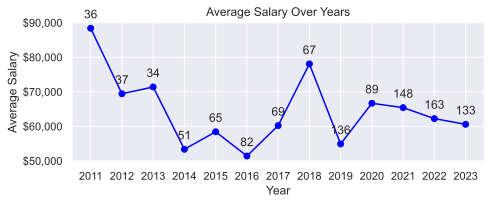

In [4]:
# make some plots

salary_means = job_df.groupby('Year')['salary_mean'].mean()

year_counts = job_df.groupby('Year').size()

# Plot
plt.figure(figsize=(7,3))
salary_means.plot(kind='line', marker='o', color='blue')


# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))


plt.title('Average Salary Over Years')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)

# Annotate each point with the number of rows (job listings) for the year
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.xticks(range(2011, 2024));
plt.show()


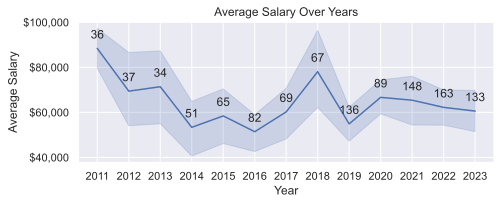

In [10]:
plt.figure(figsize=(7,3))
sns.lineplot(data=job_df, x="Year", y="salary_mean") # for error bar

plt.title('Average Salary Over Years')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)

# Annotate each point with the number of rows (job listings) for the year
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.xticks(range(2011, 2024));

# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.show()


In [16]:
pd.set_option('display.max_colwidth', 100) # set length of description
comparison_cols = ['Salary', 'Salary low end', 'salary_low_end_sg', 'Salary high end', 'salary_high_end_sg', 'Pay basis', 'pay_basis_sg', 'Job Title', 'job_title_sg', 'Employer', 'employer_sg', 'state_full_name_sg', 'Description']
job_df.sample(2)[comparison_cols]

# job_df[job_df['salary_low_end_sg'].isna() & job_df['salary_high_end_sg'].notna()][comparison_cols]

,Salary,Salary low end,salary_low_end_sg,Salary high end,salary_high_end_sg,Pay basis,pay_basis_sg,Job Title,job_title_sg,Employer,employer_sg,state_full_name_sg,Description
1485,NaN,NaN,57324.00,NaN,77028.00,yearly,yearly,Publications and Clearinghouse Program Specialist,Publications and Clearinghouse Program Specialist – Certification and Training Program,Washington Secretary of State’s Office.,Washington Secretary of State’s Office,Washington,"Publications and Clearinghouse Program Specialist – Certification and Training Program, Washingt..."
2138,$5094.59- $6355.07,5094.59,61135.08,6355.07,76260.84,yearly,monthly,Election Hardware Manager,Election Hardware Manager,"Dallas County, Texas",Dallas County,Texas,"Election Hardware Manager, Dallas County, Texas— Manages the lifecycle of election hardware by d..."


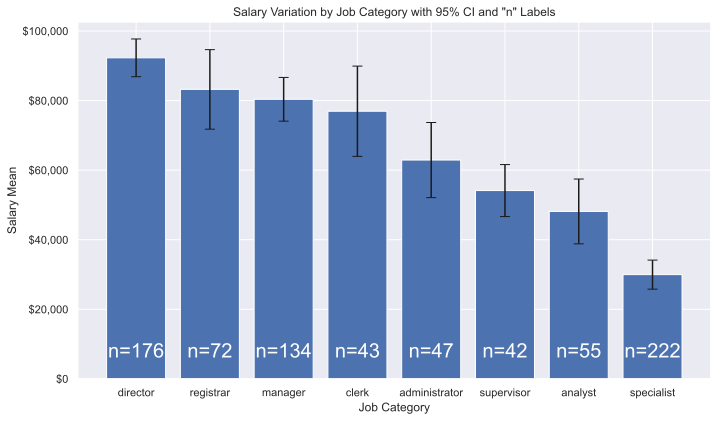

In [101]:
titles = ['director', 'registrar', 'manager', 'clerk', 'administrator', 'supervisor', 'analyst', 'specialist']
for title in titles:
    job_df.loc[job_df['job_title_sg'].str.lower().str.contains(title, na=False), 'seniority'] = title

category_order = pd.CategoricalDtype(categories=titles, ordered=True)
job_df['seniority'] = job_df['seniority'].astype(category_order)

# Group the data by 'Category' and calculate the mean and standard deviation of salaries
grouped_data = job_df.groupby('seniority', observed=True)['salary_mean'].agg(['mean', 'size', 'std']).reset_index()

grouped_data['ci'] = grouped_data.apply(lambda row: sps.t.interval(0.95, row['size'] - 1, loc=row['mean'], scale=row['std'] / (row['size'] ** 0.5)), axis=1)

# Extract lower and upper CI bounds
grouped_data['ci_lower'] = grouped_data['ci'].apply(lambda x: x[0])
grouped_data['ci_upper'] = grouped_data['ci'].apply(lambda x: x[1])


# Create the bar chart with 95% CI error bars and "n" labels
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_data['seniority'], grouped_data['mean'], yerr=[grouped_data['mean'] - grouped_data['ci_lower'], grouped_data['ci_upper'] - grouped_data['mean']], capsize=5)

# Add "n" labels on top of each bar
for bar, n in zip(bars, grouped_data['size']):
    plt.text(bar.get_x() + bar.get_width() / 2, 5000, f'n={n}', ha='center', va='bottom', fontsize=20, color='w')

plt.xlabel('Job Category')
plt.ylabel('Salary Mean')
plt.title('Salary Variation by Job Category with 95% CI and "n" Labels')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()


# Part E: Scrape OpenTheBooks

In [142]:
# load in excel doc
state = pd.read_excel('/Users/will/Repos/election-jobs/State Election Offices.xlsx')


# the above file was previously processed from  just the State and Employer columns (provided by Grace)
# using the below code.
# and then i made some manual changes to DC and TN div of elections
# Function to format office name
# def format_office_name(office_name):
#     # Use urllib.parse.quote to URL encode the office name
#     return quote(office_name)

# # Construct the URLs for each row in the DataFrame
# base_url = 'https://www.openthebooks.com/'
# urls = []

# for index, row in df.iterrows():
#     state_name = row['State'].lower().replace(' ', '-')
#     office_name = quote(row['Employer'])
#     url = f'{base_url}{state_name}-state-employees/?Year_S=0&Emp_S={office_name}'
#     urls.append(url)


In [234]:
state.loc[11]

State                                                                                                  Delaware
Employer                                                            State of Delaware Commissioner of Elections
Notes                                                                                                       NaN
URL         https://www.openthebooks.com/delaware-state-employees/?Year_S=0&Emp_S=State%20of%20Delaware%20Co...
Name: 11, dtype: object

In [242]:
# exclude=['California', 'District of Columbia', 'Hawaii'] # delaware was partially excluded.
df_continue = state.loc[i+1:]
for i, row in tqdm(df_continue.iterrows(), total=df_continue.shape[0]):
    if row['State'] not in exclude:
        dir_path = f"openthebooks/{row['State']}"
        os.makedirs(dir_path, exist_ok=True)
        
        # Send an HTTP GET request with headers
        response = requests.get(row['URL'], headers=headers)
    
        filename = f"{''.join(urlparse(row['URL'])[2:]).replace('/', '|')}.html"
    
        soup = BeautifulSoup(response.text, 'html.parser')
        with open(f"{dir_path}/{filename}", 'w') as f:
            f.write(response.text)
        
        while soup.find('li', class_='pg-next'): # while there are more pages
            next_link = soup.find('li', class_='pg-next').a['href']
            next_url = urljoin(base_url, soup.find('li', class_='pg-next').a['href'])
    
            response = requests.get(next_url, headers=headers)
            filename = f"{''.join(urlparse(next_url)[2:]).replace('/', '|')}.html"
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            with open(f"{dir_path}/{filename}", 'w') as f:
                f.write(response.text)
        


    # soup = BeautifulSoup(response.text, 'html.parser')
    
    # weeks = soup.find('ul', class_='weeks').find_all('li')
    # weeks = [f"{base_url}{week.find('a')['href']}" for week in weeks]
